In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [53]:
!pip install striprtf;

In [54]:
from sklearn.preprocessing import StandardScaler
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import warnings
from striprtf.striprtf import rtf_to_text
from nltk.corpus import stopwords
import seaborn as sns
import re 
import nltk
from scipy.sparse import csr_matrix
import numpy as np
from collections import Counter
nltk.download('wordnet')
warnings.filterwarnings("ignore")
np.set_printoptions(suppress=True) 

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [55]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [56]:
df = pd.read_csv("spam_or_ham.csv")
df.head()

Category                                            Message Unnamed: 2  \
0      ham  Go until jurong point, crazy.. Available only ...        NaN   
1      ham                      Ok lar... Joking wif u oni...        NaN   
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3      ham  U dun say so early hor... U c already then say...        NaN   
4      ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN

In [57]:
#For sms dataset
df = df.rename(columns={"Message":"content","Category":"category"})
df.category = (df.category == 'spam').astype("int")
df.head()

category                                            content Unnamed: 2  \
0         0  Go until jurong point, crazy.. Available only ...        NaN   
1         0                      Ok lar... Joking wif u oni...        NaN   
2         1  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3         0  U dun say so early hor... U c already then say...        NaN   
4         0  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN

In [58]:

stopwords_list = stopwords.words('english')

In [59]:
df.shape

(5572, 5)

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   category    5572 non-null   int32 
 1   content     5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: int32(1), object(4)
memory usage: 196.0+ KB


In [61]:
# drop last 3 cols
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)

In [62]:
df['category'].value_counts()

0    4825
1     747
Name: category, dtype: int64

In [63]:
import matplotlib.pyplot as plt
plt.pie(df['category'].value_counts(), labels=['ham','spam'],autopct="%0.2f")
plt.show()

In [64]:
df['num_characters'] = df['content'].apply(len)

In [65]:
df.head()

category                                            content  num_characters
0         0  Go until jurong point, crazy.. Available only ...             111
1         0                      Ok lar... Joking wif u oni...              29
2         1  Free entry in 2 a wkly comp to win FA Cup fina...             155
3         0  U dun say so early hor... U c already then say...              49
4         0  Nah I don't think he goes to usf, he lives aro...              61

In [66]:
count1 = Counter(" ".join(df[df['category']==0]["content"]).split()).most_common(20)
df1 = pd.DataFrame.from_dict(count1)
df1 = df1.rename(columns={0: "words in non-spam", 1 : "count"})
count2 = Counter(" ".join(df[df['category']==1]["content"]).split()).most_common(20)
df2 = pd.DataFrame.from_dict(count2)
df2 = df2.rename(columns={0: "words in spam", 1 : "count_"})

In [67]:
df1.plot.bar(legend = False)
y_pos = np.arange(len(df1["words in non-spam"]))
plt.xticks(y_pos, df1["words in non-spam"])
plt.title('More frequent words in non-spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

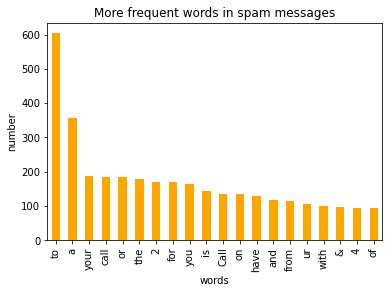

In [68]:
df2.plot.bar(legend = False, color = 'orange')
y_pos = np.arange(len(df2["words in spam"]))
plt.xticks(y_pos, df2["words in spam"])
plt.title('More frequent words in spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

In [69]:
STOPWORDS = stopwords.words('english')


In [70]:
m=1000 #Hyperparameter 1

In [71]:
contractions_df = pd.read_csv('english_contractions.csv')
contractions_list = contractions_df.Contraction.values
#converting all the contractions to lower case
contractions_list = list(map(lambda word:word.lower(),contractions_list))

In [72]:
def get_num_of_occurences(df,word_list):
    word_know=word_list
    count=0
    frequency_spam = {k:0 for k in word_know}
    frequency_ham  = {k:0 for k in word_know}
    count=count+1
    def get_number_of_words(content,words_list,category):
        count=1
        content_split = content.lower().split()
        n_words = 0
        count=count+1
        for word in content_split:
            if word in words_list:
                n_words +=1
                count=count+1
                if category ==1:
                    count=count+1
                    frequency_spam[word]+=1
                if category ==0:
                    count=count+1
                    frequency_ham[word]+=1

        return n_words

    number_of_occurences  = np.zeros(len(df),dtype = np.int8)
    count=1
    n=len(df)
    for i in range(n):
        k=df.iloc[i]
        content = k.content   
        d=df.iloc[i].content
        contents = content 
        number_of_occurences[i] = get_number_of_words(contents,word_list,d)

    return number_of_occurences,frequency_spam,frequency_ham

def print_most_common(freq):
    d=freq.items()
    e=True
    freq = sorted(d,key = lambda x: x[1],reverse=e)
    m=len(freq)
    for i in range(m):
        word = freq[i][0]
        j=i
        var=1
        fr = freq[j][var]

        if i>10 or f==0:
            break
        else:
            print("{:5} : {}".format(word,fr))
            

In [73]:
def to_lower(sentence):
    a=sentence.lower()
    return a

#f in the function name denotes indicates that it is a function
def remove_stopwords_f(sentence):
    a=sentence.lower()
    sentence_split = a.split()
    new_sentence = []
    lista=stopwords_list
    for word in sentence_split:
        if word not in lista:
            new_sentence.append(word)
    return " ".join(new_sentence)

def remove_contractions_f(sentence):
    a=sentence.lower()
    sentence_split = a.split()
    new_sentence = []
    for word in sentence_split:
        if word not in contractions_list:
            new_sentence.append(word)
    return " ".join(new_sentence)

def remove_numbers_f(sentence):
    b=sentence
    return re.sub('[0-9]+','',b)

def remove_special_char_f(sentence):
    b=sentence
    return re.sub('[^a-zA-Z0-9\s]','',b)

In [74]:
def get_word_list_and_count(df,ngram = 1,category=1,max_number=10,
                            remove_stopwords=False,remove_numbers=False,remove_contractions=False):
    n=max_number
    cv = CountVectorizer(max_features=n,ngram_range=(ngram,ngram))
    count=0
    #getting the required content in the required form
    z=df.category==category
    content_series = df[z].content
    if remove_stopwords:
        count=count+1
        content_series = content_series.apply(remove_stopwords_f)

    if remove_contractions:
        count=count+1
        content_series = content_series.apply(remove_contractions_f)

    if remove_numbers:
        count=count+1
        content_series = content_series.apply(remove_numbers_f)
    count=count+1
    content_vectorised = cv.fit_transform(content_series).toarray()
    word_list = cv.get_feature_names()
    count=count+1
    word_count = content_vectorised.sum(axis=0)
    word_count_dict = dict(zip(word_list,word_count))
    count=count+1
    
    return pd.Series(word_count_dict).sort_values(ascending =False)

In [75]:
def add_contractions_stopwords_stat(df):
    df = df.copy()
    count=0
    number_of_contractions_data = get_num_of_occurences(df,contractions_list)
    count=count+1
    number_of_stopwords_data = get_num_of_occurences(df,stopwords_list)
    count=count+1
    df['contractions_count'] = number_of_contractions_data[0]
    count=count+1
    df['stopwords_count'] = number_of_stopwords_data[0]
    count=count+1
    cache = {"contractions":number_of_contractions_data,"stopwords":number_of_stopwords_data}
    return df

In [76]:
def add_specialchar_numericalchar_stat(df):
    df = df.copy()
    n=len(df)
    m=np.zeros(n,dtype = np.int8)
    number_of_special_char  = m
    number_of_numerical_char  = m

    for i in range(n):
        k=df.iloc[i]
        content = k.content
        d=len(re.findall(r"[^a-zA-Z0-9\s',.]+",content))
        number_of_special_char[i] = d
        e=len(re.findall(r'[0-9]+',content))
        number_of_numerical_char[i] = e

    df['special_character_count'] = number_of_special_char
    df['numerical_characters_count'] = number_of_numerical_char

    return df

In [77]:
df = add_contractions_stopwords_stat(df)
df = add_specialchar_numericalchar_stat(df)

In [78]:
df.head()

category                                            content  \
0         0  Go until jurong point, crazy.. Available only ...   
1         0                      Ok lar... Joking wif u oni...   
2         1  Free entry in 2 a wkly comp to win FA Cup fina...   
3         0  U dun say so early hor... U c already then say...   
4         0  Nah I don't think he goes to usf, he lives aro...   

   num_characters  contractions_count  stopwords_count  \
0             111                   0                4   
1              29                   0                0   
2             155                   0                5   
3              49                   0                2   
4              61                   1                6   

   special_character_count  numerical_characters_count  
0                        0                           0  
1                        0                           0  
2                        6                           6  
3                        0                           0  
4                        0                           0

In [79]:
features = ['content', 'contractions_count',
       'stopwords_count', 'special_character_count',
       'numerical_characters_count']
df.drop(['num_characters'], axis=1)

category                                            content  \
0            0  Go until jurong point, crazy.. Available only ...   
1            0                      Ok lar... Joking wif u oni...   
2            1  Free entry in 2 a wkly comp to win FA Cup fina...   
3            0  U dun say so early hor... U c already then say...   
4            0  Nah I don't think he goes to usf, he lives aro...   
...        ...                                                ...   
5567         1  This is the 2nd time we have tried 2 contact u...   
5568         0              Will Ì_ b going to esplanade fr home?   
5569         0  Pity, * was in mood for that. So...any other s...   
5570         0  The guy did some bitching but I acted like i'd...   
5571         0                         Rofl. Its true to its name   

      contractions_count  stopwords_count  special_character_count  \
0                      0                4                        0   
1                      0                0                        0   
2                      0                5                        6   
3                      0                2                        0   
4                      1                6                        0   
...                  ...              ...                      ...   
5567                   0               10                        7   
5568                   0                2                        0   
5569                   0                4                        0   
5570                   0               12                        0   
5571                   0                3                        0   

      numerical_characters_count  
0                              0  
1                              0  
2                              6  
3                              0  
4                              0  
...                          ...  
5567                           7  
5568                           0  
5569                           0  
5570                           0  
5571                           0  

[5572 rows x 6 columns]

In [80]:
print('After Using N-Gram the most commonly Trigrams in Spam Emails:')
print('\n')
get_word_list_and_count(df,ngram=3,category=1,max_number=5,remove_stopwords=False,remove_numbers=False)

After Using N-Gram the most commonly Trigrams in Spam Emails:




you have won             37
prize guaranteed call    21
1000 cash or             19
find out who             18
from land line           18
dtype: int64

In [81]:
print('After Using N-Gram the most commonly Trigrams in Ham Emails:')
print('\n')
get_word_list_and_count(df,ngram=3,category=0,max_number=5,remove_stopwords=False,remove_numbers=False)

After Using N-Gram the most commonly Trigrams in Ham Emails:




ll call later    39
how are you      38
sorry ll call    38
let me know      26
where are you    23
dtype: int64

In [82]:
def lemmatize(sentence):
    wnl = WordNetLemmatizer()
    sentence = sentence.split()
    sent=sentence
    count=0
    sentence = [wnl.lemmatize(word) for word in sent]
    count=count+1
    sentence =  " ".join(sentence)
    return sentence

def process_sentence_with_conditions(sentence,remove_stopwords=True,remove_contractions=True,
                     remove_numbers = True,remove_special_char=True,lemmatize_sentence = True):
    count=0
    a=sentence.lower()
    sentence = a

    #these functions were defined earlier
    if remove_stopwords:
        c=remove_stopwords_f(sentence)
        sentence =  c

    if remove_contractions:
        d=remove_contractions_f(sentence)
        sentence = d

    if remove_numbers:
        e=remove_numbers_f(sentence)
        sentence = e
        
    if remove_special_char:
        f=remove_special_char_f(sentence)
        sentence = f
    
    if lemmatize_sentence:
        g=lemmatize(sentence)
        sentence = g

    return sentence

def process_sentence(sentence):
    val=True
    return process_sentence_with_conditions(sentence,val,val,val,val,val) 

In [83]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [84]:
df_c = df.copy()
df_c.content = df_c.content.apply(process_sentence)  

In [85]:
df_X_train,df_X_test,y_train,y_test = train_test_split(df_c[features],df_c.category,test_size=0.25)

In [86]:
#It can be chosen to include or exclude the following features
include_number_of_contractions = False
include_number_of_stopwords = False

In [87]:
a=include_number_of_contractions
b=include_number_of_stopwords

In [88]:
vectoriser = TfidfVectorizer(max_features=m)
vectoriser.fit(df_X_train.content);

In [89]:
def get_X(df_X,vectoriser,n_contractions=False,
                         n_stopwords=False,n_numbers=False,n_special_char=False):
    
    X = vectoriser.transform(df_X.content).toarray()

    pos=1
    neg=-1
    value=True
    if n_contractions == value:
        k=df_X.contractions_count.values
        num_contractions_array_train = np.reshape(k,(neg,pos))
        X = np.hstack((X,num_contractions_array_train))

    if n_stopwords == value:
        l=df_X.stopwords_count.values
        num_stopwords_array_train = np.reshape(l,(neg,pos))
        X = np.hstack((X,num_stopwords_array_train))

    if n_special_char == value:
        m=df_X.special_character_count.values
        num_special_array_train = np.reshape(m,(neg,pos))
        X = np.hstack((X,num_special_array_train))
        
    if n_numbers == value:
        o=df_X.numerical_characters_count.values
        num_numbers_array_train = np.reshape(o,(neg,pos))
        X = np.hstack((X,num_numbers_array_train))
       
    return X  

In [90]:
#It can be chosen to include or exclude the following features
include_number_of_numericalchar = True
include_number_of_specialchar = True

In [91]:
c=include_number_of_numericalchar
d=include_number_of_specialchar

In [92]:
X_train = get_X(df_X_train,vectoriser,a,b,c,d)
X_test = get_X(df_X_test,vectoriser,a,b,c,d)
y_train,y_test = np.array(y_train),np.array(y_test)

In [93]:
def accuracy_score(y_true,y_preds):
    z=y_true==y_preds
    k=(z).sum()
    n=k/len(y_true)
    return n

def access_model_train(clf,X,y):
    print("Training Dataset Result")
    y_preds = clf.predict(X)
    count=0
    print("Accuracy: %.4f"%accuracy_score(y,y_preds))
    count=count+1
    print("\nConfusion Matrix for Train Data")
    cm = confusion_matrix(y,y_preds)
    count=count+1
    sns.heatmap(cm,cmap="cubehelix_r",annot=True,fmt='g')
    plt.xticks([])
    plt.yticks([])
    count=count+1
    plt.show()
def access_model_test(clf,X,y):
    print("**********")
    print('Testing Dataset Result')
    y_preds = clf.predict(X)
    count=0
    print("Accuracy: %.4f"%accuracy_score(y,y_preds))
    count=count+1
    print("\nConfusion Matrix for Test Data")
    count=count+1
    cm = confusion_matrix(y,y_preds)
    sns.heatmap(cm,cmap="Pastel1_r",annot=True,fmt='g')
    plt.xticks([])
    plt.yticks([])
    count=count+1
    plt.show()    

In [94]:
history = {'parameters':[],'accuracy_train':[],'accuracy_test':[],'model':[]}
X_train_sparse = csr_matrix(X_train)
X_test_sparse = csr_matrix(X_test)
parameters = {'kernel':['linear', 'rbf','poly','sigmoid'], 'C':[1,3,5,7],'gamma':['auto','scale']}#Hyperparameter tuning parameter

In [95]:
iteration=0
for kernel in parameters['kernel']:
    iteration=iteration+1
    for C in parameters['C']:
        for gamma in parameters['gamma']:
            clf = make_pipeline(StandardScaler(with_mean=False), svm.SVC(kernel = kernel,gamma=gamma,C=C))
            iteration=iteration+1
            clf.fit(X_train_sparse, y_train)
            parameter_comb = {"kernel":kernel,"C":C,"gamma":gamma}
            iteration=iteration+1
            accuracy_train = accuracy_score(y_train,clf.predict(X_train_sparse))
            accuracy_test = accuracy_score(y_test,clf.predict(X_test_sparse))
            iteration=iteration+1
            
            history['parameters'].append(parameter_comb)
            history['accuracy_train'].append(accuracy_train)
            iteration=iteration+1
            history['accuracy_test'].append(accuracy_test)
            history['model'].append(clf)
            iteration=iteration+1

In [96]:
maxi=max(history['accuracy_test'])
i = history['accuracy_test'].index(maxi)
best_model = history['model'][i]

In [97]:
print("Model Best Results are given below:")
print("\n")
print("Training Dataset Accuracy")
print(history['accuracy_train'][i])
print("\n")
print("Test Dataset Accuracy")
print(history['accuracy_test'][i])
print("\n")
print("Best Parameters after Hyperparameter tuning")
print(history['parameters'][i])
print("\n")

Model Best Results are given below:


Training Dataset Accuracy
0.9854032065087341


Test Dataset Accuracy
0.9856424982053122


Best Parameters after Hyperparameter tuning
{'kernel': 'sigmoid', 'C': 1, 'gamma': 'auto'}




Training Dataset Result
Accuracy: 0.9854

Confusion Matrix for Train Data


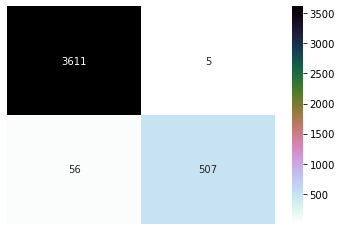

**********
Testing Dataset Result
Accuracy: 0.9856

Confusion Matrix for Test Data


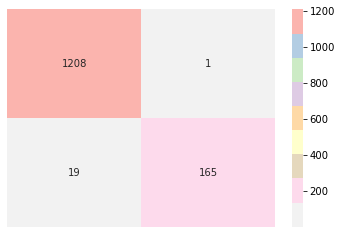

In [98]:
access_model_train(best_model,X_train,y_train)
access_model_test(best_model,X_test,y_test)

# Testing our Results

In [99]:
def get_number_of_words(content,words_list):
    a=content.lower()
    content_split = a.split()
    n_words = 0
    count=0
    for word in content_split:
        if word in words_list:
            count=count+1;
            n_words +=1
    return n_words

def get_sentence_to_features_vector(sentence):
    sen=sentence
    count=0
    contractions = get_number_of_words(sen,contractions_list)
    stopwords = get_number_of_words(sen,stopwords_list)
    count=count+1
    special_char = len(re.findall(r"[^a-zA-Z0-9\s',.]+",sen))
    numerical_char = len(re.findall(r'[0-9]+',sen))
    count=count+1
    processed_sentence = process_sentence(sentence)
    features_vector = vectoriser.transform([sentence]).toarray()
    count=count+1
    if include_number_of_contractions:
        feature1=np.array([[contractions]])
        features_vector =  np.hstack((features_vector,feature1))
        
    if include_number_of_stopwords:
        feature2=np.array([[stopwords]])
        features_vector = np.hstack((features_vector,feature2))

    if include_number_of_specialchar:
        feature3=np.array([[special_char]])
        features_vector = np.hstack((features_vector,feature3))

    if include_number_of_numericalchar:
        feature4=np.array([[numerical_char]])
        features_vector = np.hstack((features_vector,feature4))
    return features_vector

#for testing an unseen dataframe with new mails 
def get_X_unseen(df_unseen):
    X_unseen = []
    count=0
    item=0
    for mail in df_unseen.content:
        count=count+1
        X_unseen.append(get_sentence_to_features_vector(mail))
    item=item+1
    return np.squeeze(np.array(X_unseen))

def test_input(model):
    x0_vector = get_sentence_to_features_vector(input('Enter the Mail Content: '))
    prediction = model.predict(x0_vector)
    print('The Mail is',(1-prediction[0])*'NOT a spam mail'+prediction[0]*'a spam mail')

In [100]:
import os
def get_predictions(model):
    item=0
    email_names = os.listdir('./test')
    item=item+1
    predictions = []
    for filename in email_names:
        item=item+1
        if "email" in filename:
            f = open("test/"+filename,encoding="utf8")
            content = f.read()
            item=item+1
            content = rtf_to_text(content)
            f.close()   
            item=item+1
            x0_vector = get_sentence_to_features_vector(content)
            prediction = model.predict(x0_vector).item()
            item=item+1
            predictions.append(prediction)
        else:
            item=item-1
            print("Invalid File Name: ",filename)
    return predictions

In [101]:
get_predictions(best_model)

[1, 0]